# Capstone Project
## The Battle of Neighborhoods (Week 2)

### Introduction

A Mexican chef who moved to New York wants to open a fast food chain of Mexican food. However, He would like to start the business in Manhattan and needs to know if opening the first store there is a good idea.

### Data

NY data containing the neighborhoods and boroughs, latitudes, and longitudes from: https://cocl.us/new_york_dataset
Data related to locations of mexican restaurants will be obtained via the FourSquare API.

### Methodology

Collect data from NY neighborhoods.
Target to Manhattan data.
Check which are the main commercial establishments in Manhattan.

### Import Libraries

In [6]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!pip install geopy
import geopy
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!pip install folium
import folium

print('Done')

     |█████████████████████████████▎  | 102kB 20.0MB/s eta 0:00:01     |████████████████████████████████| 112kB 20.0MB/s 
Done


### Import Data

In [7]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Done')

Done


In [8]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [9]:
neighborhoods_data = newyork_data['features']

In [10]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [11]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

neighborhoods = pd.DataFrame(columns=column_names)

In [12]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [13]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [14]:
print('{} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    ))

5 boroughs and 306 neighborhoods.


In [15]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Geograpical coordinate of NY City are {}, {}.'.format(latitude, longitude))

Geograpical coordinate of NY City are 40.7127281, -74.0060152.


In [17]:
#### Segment the data to Manhattan neighborhood

manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [18]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

Geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [19]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [20]:
CLIENT_ID = 'XZGZDWG0BTPY2I04DUASS22HOWTX0YT3HFOZ5JCHEADSVIOP'
CLIENT_SECRET = 'UTWWKIGMT4EMQEW35LEZ2AUNODQOM3VRLIU523LYDMTO5DR1'
VERSION = '20200710'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XZGZDWG0BTPY2I04DUASS22HOWTX0YT3HFOZ5JCHEADSVIOP
CLIENT_SECRET:UTWWKIGMT4EMQEW35LEZ2AUNODQOM3VRLIU523LYDMTO5DR1


In [21]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

In [22]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude']
neighborhood_longitude = manhattan_data.loc[0, 'Longitude']

neighborhood_name = manhattan_data.loc[0, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


In [23]:
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=XZGZDWG0BTPY2I04DUASS22HOWTX0YT3HFOZ5JCHEADSVIOP&client_secret=UTWWKIGMT4EMQEW35LEZ2AUNODQOM3VRLIU523LYDMTO5DR1&v=20200710&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

In [24]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f0cd49c1582505d8fd3e0dc'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 24,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

In [25]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [26]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Starbucks,Coffee Shop,40.877531,-73.905582
4,Astral Fitness & Wellness Center,Gym,40.876705,-73.906372


In [27]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

24 venues were returned by Foursquare.


### Results

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [30]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3180, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym


In [33]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,68,68,68,68,68,68
Carnegie Hill,94,94,94,94,94,94
Central Harlem,44,44,44,44,44,44
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,42,42,42,42,42,42
East Village,100,100,100,100,100,100


In [34]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 326 uniques categories.


In [35]:
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,

In [36]:
manhattan_onehot.shape

(3180, 327)

In [37]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,

In [38]:
manhattan_grouped.shape

(40, 327)

In [39]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.10
1          Hotel  0.07
2            Gym  0.06
3    Coffee Shop  0.06
4  Memorial Site  0.04


----Carnegie Hill----
                venue  freq
0         Coffee Shop  0.07
1                Café  0.05
2         Pizza Place  0.04
3  Italian Restaurant  0.04
4         Yoga Studio  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1   Chinese Restaurant  0.05
2                  Bar  0.05
3  American Restaurant  0.05
4       Cosmetics Shop  0.05


----Chelsea----
                 venue  freq
0          Coffee Shop  0.09
1          Art Gallery  0.06
2  American Restaurant  0.04
3               Bakery  0.03
4               Market  0.02


----Chinatown----
                venue  freq
0  Chinese Restaurant  0.08
1              Bakery  0.05
2        Cocktail Bar  0.04
3        Dessert Shop  0.04
4                 Bar  0.03


----Civic Center----
                  venue  freq
0           

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [60]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(50)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Battery Park City,Park,Hotel,Gym
1,Carnegie Hill,Coffee Shop,Café,Pizza Place
2,Central Harlem,African Restaurant,Bar,American Restaurant
3,Chelsea,Coffee Shop,Art Gallery,American Restaurant
4,Chinatown,Chinese Restaurant,Bakery,Dessert Shop
5,Civic Center,Coffee Shop,Gym / Fitness Center,Hotel
6,Clinton,Italian Restaurant,Theater,Gym / Fitness Center
7,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant
8,East Village,Bar,Pizza Place,Ice Cream Shop
9,Financial District,Coffee Shop,Pizza Place,American Restaurant


In [47]:
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

kmeans.labels_[0:3] 

array([3, 1, 4], dtype=int32)

In [61]:
manhattan_merged.head(50) 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Sandwich Place,Gym,Coffee Shop
1,Manhattan,Chinatown,40.715618,-73.994279,4,Chinese Restaurant,Bakery,Dessert Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Chinese Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,4,Mexican Restaurant,Café,Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,Pizza Place,Café,Coffee Shop
5,Manhattan,Manhattanville,40.816934,-73.957385,4,Coffee Shop,Deli / Bodega,Mexican Restaurant
6,Manhattan,Central Harlem,40.815976,-73.943211,4,African Restaurant,Bar,American Restaurant
7,Manhattan,East Harlem,40.792249,-73.944182,4,Mexican Restaurant,Bakery,Thai Restaurant
8,Manhattan,Upper East Side,40.775639,-73.960508,1,Italian Restaurant,Coffee Shop,Bakery
9,Manhattan,Yorkville,40.775930,-73.947118,1,Italian Restaurant,Gym,Bar


NameError: name 'plt' is not defined

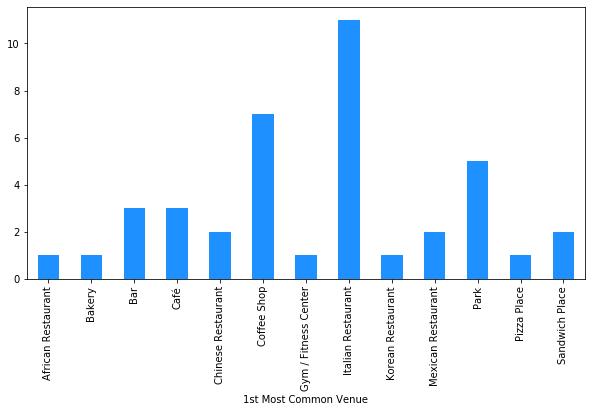

In [76]:
clr = "dodgerblue"
manhattan_merged.groupby('1st Most Common Venue')['Borough'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Most common bussines in Manhattan', fontsize = 20)
plt.xlabel('1st Most Common Venue', fontsize = 15)
plt.ylabel('Borough',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

### Conclusion

With the data we can see that there is a possibility to open a Mexican fast food in Manhattan, as there are only two Mexican restaurants in the region.